<a href="https://colab.research.google.com/github/udlbook/udlbook/blob/main/Notebooks/Chap10/10_5_Convolution_For_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.5: Convolution for MNIST**

This notebook builds a proper network for 2D convolution.  It works with the MNIST dataset (figure 15.15a), which was the original classic dataset for classifying images.  The network will take a 28x28 grayscale image and classify it into one of 10 classes representing a digit.

The code is adapted from https://nextjournal.com/gkoehler/pytorch-mnist

Work through the cells below, running each cell in turn. In various places you will see the words "TO DO". Follow the instructions at these places and make predictions about what is going to happen or write code to complete the functions.

Contact me at udlbookmail@gmail.com if you find any mistakes or have any suggestions.


In [6]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <D400622C-0C6B-3AE1-AB45-F1D0BF19B384> /Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/transformers/utils/generic.py:

In [10]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('./data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:01<00:00, 6600944.33it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 906901.15it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4613756.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3480820.17it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



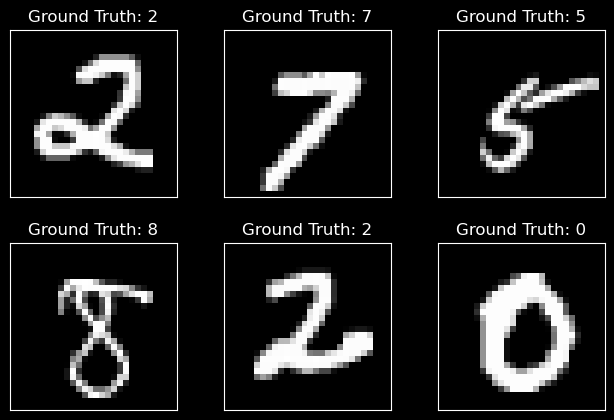

In [11]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

Define the network.  This is a more typical way to define a network than the sequential structure.  We define a class for the network, and define the parameters in the constructor.  Then we use a function called forward to actually run the network.  It's easy to see how you might use residual connections in this format.

In [12]:
from os import X_OK
# TODO Change this class to implement
# 1. A valid convolution with kernel size 5, 1 input channel and 10 output channels
# 2. A max pooling operation over a 2x2 area
# 3. A Relu
# 4. A valid convolution with kernel size 5, 10 input channels and 20 output channels
# 5. A 2D Dropout layer
# 6. A max pooling operation over a 2x2 area
# 7. A relu
# 8. A flattening operation
# 9. A fully connected layer mapping from (whatever dimensions we are at-- find out using .shape) to 50
# 10. A ReLU
# 11. A fully connected layer mapping from 50 to 10 dimensions
# 12. A softmax function.

# Replace this class which implements a minimal network (which still does okay)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Convolutional layer: 1 input channel, 10 output channels, kernel size 5
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=0)  # valid padding
        # Max pooling: 2x2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Convolutional layer: 10 input channels, 20 output channels, kernel size 5
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=0)  # valid padding
        # Max pooling: 2x2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Dropout for 2D convolutions
        self.drop = nn.Dropout2d(p=0.5)  # Example dropout rate of 0.5
        # Fully connected layer: size to be determined
        self.fc1 = nn.Linear(20 * 4 * 4, 50)  # Adjust the input features after flattening
        self.fc2 = nn.Linear(50, 10)  # Final layer to 10 classes
    
    def forward(self, x):
        # Convolutional layer followed by max pooling and ReLU
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.relu(x)
        
        # Convolutional layer followed by max pooling, dropout, and ReLU
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.drop(x)
        
        # Flattening
        x = x.flatten(start_dim=1)
        
        # Fully connected layers with ReLU activation and softmax
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)  # Log softmax for classification
        
        return x

In [13]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [14]:
# Create network
model = Net()
# Initialize model weights
model.apply(weights_init)
# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [15]:
# Main training routine
def train(epoch):
  model.train()
  # Get each
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    # Store results
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{}]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset), loss.item()))

In [16]:
# Run on test data
def test():
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [17]:
# Get initial performance
test()
# Train for three epochs
n_epochs = 3
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/Users/sibivishtan/anaconda3/envs/learning_dl/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.4004, Accuracy: 1022/10000 (10%)

Train Epoch: 1 [0/60000]	Loss: 2.420823
Train Epoch: 1 [640/60000]	Loss: 2.239226
Train Epoch: 1 [1280/60000]	Loss: 2.148579
Train Epoch: 1 [1920/60000]	Loss: 2.115948
Train Epoch: 1 [2560/60000]	Loss: 2.045696
Train Epoch: 1 [3200/60000]	Loss: 1.842298
Train Epoch: 1 [3840/60000]	Loss: 1.584153
Train Epoch: 1 [4480/60000]	Loss: 1.447806
Train Epoch: 1 [5120/60000]	Loss: 1.353814
Train Epoch: 1 [5760/60000]	Loss: 1.248760
Train Epoch: 1 [6400/60000]	Loss: 0.750071
Train Epoch: 1 [7040/60000]	Loss: 0.946601
Train Epoch: 1 [7680/60000]	Loss: 0.906430
Train Epoch: 1 [8320/60000]	Loss: 0.944059
Train Epoch: 1 [8960/60000]	Loss: 0.638684
Train Epoch: 1 [9600/60000]	Loss: 0.862943
Train Epoch: 1 [10240/60000]	Loss: 0.625984
Train Epoch: 1 [10880/60000]	Loss: 0.571999
Train Epoch: 1 [11520/60000]	Loss: 0.657968
Train Epoch: 1 [12160/60000]	Loss: 0.543199
Train Epoch: 1 [12800/60000]	Loss: 0.453786
Train Epoch: 1 [13440/60000]	Loss: 0.5

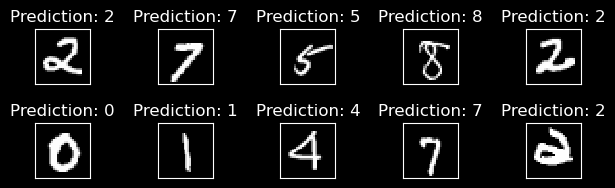

In [18]:
# Run network on data we got before and show predictions
output = model(example_data)

fig = plt.figure()
for i in range(10):
  plt.subplot(5,5,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
plt.show()